In [13]:
import glob
import numpy as np
import xarray as xr 
from scipy import interpolate
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

In [14]:
# Load Erik's reference mass balance runs for the 25 parameter
# combinations which statisfy his tuning criteria
MB_ref =  xr.open_dataset("../MB_tune/Young_etal_2020_ref_MB.nc")

x = MB_ref.mean('ref_run').stack(z=('x', 'y')).Elevation.values
y = MB_ref.mean('ref_run').stack(z=('x', 'y')).MB.values

# find indexes of nans and sort indexes
mask = np.where(~np.isnan(x))
idxs = np.argsort(x[mask])

# Remove the nans and sort the data and downsample data so there are
# less verically overlappig points, causing the spline fitting to fail
x_sub = x[~np.isnan(x)][::10]
y_sub = y[~np.isnan(x)][::10]

m = len(x_sub)

idxs = np.argsort(x_sub, kind='heapsort')

x_ = x_sub[idxs]
y_ = y_sub[idxs]
w  = np.where(x_ > 3000., 10.0, 1.0 )

In [15]:
offsets = {'glc1-a'   : -1.0,
           'crmpt12'  : -0.3, 
           'crmpt18-a': "00.2", 
           'lilk-a'   : "00.1", 
           'klut-b'   : 1.5, 
           'sprg'     : 0.9, 
           'twds-b'   : 10.8, 
           'fish'     : 8.3 }


# legend labels dictionary
labels = {'glc1'    : ['South' , 0],
          'crmpt12'   : ['Glacier 12', 1],
          'crmpt18' : ['Glacier 18', 2],
          'lilk'    : ['Little Kluane', 3],
          'klun'    : ['Kluane', 4],
          'sprg'      : ['Spring', 5], 
          'klut'    : ['Klutlan', 6], 
          'twds'    : ['Tweedsmuir', 8],
          'fish'      : ['Fisher', 7]}

# hex codes from colorbrewer
colors = ['#7fc97f','#beaed4','#fdc086','#ffff99',
          '#386cb0','#f0027f','#bf5b17','#666666', '#7fc97f']


color = plt.cm.tab20b(np.linspace(0, 1,9), 9)
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', color)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']


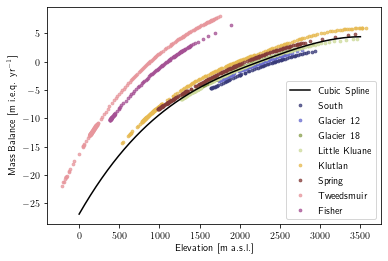

In [20]:
results_fp = "../../initialization/coarse/result/{}/nc/{}_*_{}_OFF*.nc"


fig, ax = plt.subplots(1,1) 

# smoothing factor 
s     = 1.5e3        
w     = np.where(x_ > 3000., 10.0, 1.0 )
z_full= np.linspace(0, 3500,250)

tck   = interpolate.splrep(x_, y_, w=w, k=3, s=s)
cubic = interpolate.splev(z_full, tck)

ax.plot(z_full, cubic, lw = 1.5, c='k', label = "Cubic Spline")

for i, key in enumerate(offsets): 

    file_fp = glob.glob(results_fp.format(*[key] * 2, offsets[key]))[0]
    
    #if key == 'twds-b': continue  

    with xr.open_dataset(file_fp) as src: 
            # correct for minimum ice thickness
            src["depth"] = xr.where(src.depth <= 10, 0, src.depth)
            # apply sigma coordinate transform for vertical coordinate
            src["Z"]     = src.zbed + src.Z * src.height 
            # Calculate the magnitude of the velocity vectors
            src['vel_m'] = np.sqrt(src['velocity 1']**2 + src['velocity 2']**2) 
    
    if key == 'fish': 
        ax.scatter(src['Z'].isel(t=0, coord_2=-1), 
                   src['zs accumulation flux 2'].isel(t=0, coord_2=-1), 
                   label=labels[key.split('-')[0]][0], s=7.5, alpha=0.75)        
    else: 
        ax.scatter(src['Z'].isel(t=-1, coord_2=-1), 
                   src['zs accumulation flux 2'].isel(t=-1, coord_2=-1), 
                   label=labels[key.split('-')[0]][0], s=7.5, alpha=0.75)
        
        
    
        
plt.legend()


ax.set_ylabel('Mass Balance [m i.e.q. yr$^{-1}$]')
ax.set_xlabel('Elevation    [m a.s.l.]')


fig.savefig('/Users/andrewnolan/Desktop/SS_balance_curves.png', dpi=400, bbox_inches='tight', facecolor='w')